# TSP LP by cvxpy 
cvxpy: https://www.cvxpy.org/  
reference: https://gist.github.com/AshNguyen/3bbaef5203f574cc5a2bad255ca59069

In [10]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('solvers:', cvx.installed_solvers())

solvers: ['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'CPLEX', 'OSQP', 'CPLEX']


In [11]:
def gen_param(num):
    path = list(range(num))
    X = np.random.random(num)
    Y = np.random.random(num)
    XY = X + Y * 1j
    return num, path, X, Y, XY

def plot_path(path, edges=False, size=6):
    plt.figure(figsize=(size, size))
    cmap = plt.get_cmap("tab10")
    plt.axis([0,1,0,1], 'equal')
    plt.plot(X[path], Y[path], alpha=0.0)
    plt.scatter(X[0], Y[0], s=80, color='r', marker='o')
    if path:
        for i in range(len(path)-1):
            plt.arrow(X[path[i]], Y[path[i]], 
                      X[path[i+1]]-X[path[i]], Y[path[i+1]]-Y[path[i]], 
                      head_width=0.02, head_length=0.02, length_includes_head=True, 
                      fc=cmap(0), ec=cmap(0))
    if edges:
        for e in edges:
            plt.plot([X[e[0]], X[e[1]]], [Y[e[0]], Y[e[1]]])
    
    for i in range(num):
        plt.text(X[i], Y[i]+0.01, s=i, fontsize=10, color='gray')

In [92]:
# Generate parameters and Plot initial path
num, path, X, Y, XY = gen_param(20) # the number of nodes

dist = []
for i in path:
    dist.append([])
    for j in path:
        if i == j:
            dist[i].append(100)
        else:
            dist[i].append(abs(XY[i] - XY[j]))

#plot_path(path + [0])

## LP with MTZ subtour elimination

In [93]:
x = cvx.Variable((num, num), boolean=True)

# objective
obj = cvx.Minimize(sum([dist[i][:] * x[:][i] for i in range(num)]))

# constraints
constraints = []
for i in range(num):
    constraints += [sum([x[i][j] for j in path if i != j]) == 1]
    constraints += [sum([x[j][i] for j in path if i != j]) == 1]

In [96]:
# MTZ subtour elimination
u = cvx.Variable(num)

for i in range(1, num):
    for j in range(1, num):
        if i != j:
            constraints.append(u[i] - u[j] + num * x[i][j] <= num - 1)
            
for i in range(num):
    constraints += [u[i] >= 0]
    
prob = cvx.Problem(obj, constraints)
#opt = prob.solve(solver='GLPK_MI', verbose=False)
opt = prob.solve(solver='GLPK_MI', verbose=False)
#opt = prob.solve()

In [86]:
def subtour(x):
    x_val = np.argmax(x.value, axis=1)
    sub = [0]
    while True:
        v = x_val[sub[-1]]
        if v not in sub:
            sub.append(v)
        else:
            return sub

Optimal tour:  [0, 17, 2, 12, 3, 4, 11, 13, 5, 8, 18, 6, 9, 1, 15, 10, 14, 7, 16, 19, 0]
CPU times: user 754 µs, sys: 7 µs, total: 761 µs
Wall time: 1.17 ms
Distance: 4.215058694570304


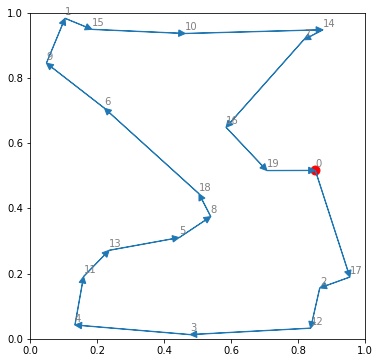

In [97]:
# results
T = subtour(x) + [0]
%time print ("Optimal tour: ", T)
plot_path(T)
tour_dist = sum([dist[T[i-1]][T[i]] for i in range(1, len(T))])
print('Distance:', tour_dist)

## LP subtour elimination with Lazy constraints

Try:  [0, 19] Nots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Try:  [0, 19, 16] Nots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18]
Try:  [0, 19, 16, 10] Nots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18]
Try:  [0, 16, 18, 19] Nots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17]
Try:  [0, 19, 18] Nots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Try:  [0, 17, 2, 12, 3, 5, 8, 18, 19] Nots: [1, 4, 6, 7, 9, 10, 11, 13, 14, 15, 16]
Try:  [0, 8, 5, 18, 19] Nots: [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Try:  [0, 19, 18, 8, 5, 13, 11, 4, 3, 12, 2, 17] Nots: [1, 6, 7, 9, 10, 14, 15, 16]
Try:  [0, 19, 8, 5, 18, 16] Nots: [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17]
Try:  [0, 17, 2, 12, 3, 5, 8, 18, 16, 19] Nots: [1, 4, 6, 7, 9, 10, 11, 13, 14, 15]
Try:  [0, 19, 16, 18, 8, 5, 13, 11, 4, 3, 12, 2, 17] Nots: [1, 6, 7, 9, 10, 14, 15]
Try:  [0, 19, 18, 10, 16] Nots: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 

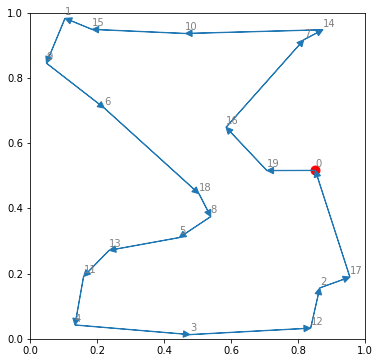

In [98]:
x = cvx.Variable((num, num), boolean=True)

# objective
obj = cvx.Minimize(sum([dist[i][:] * x[:][i] for i in range(num)]))

# basic constraints
constraints = []
for i in range(num):
    constraints += [sum([x[i][j] for j in path if i != j]) == 1]
    constraints += [sum([x[j][i] for j in path if i != j]) == 1]

prob = cvx.Problem(obj, constraints)
opt = prob.solve()

# Lazy constraints subtour elimination
while True:
    sub = subtour(x)
    if len(sub) == num:
        print ("Optimal tour: ", sub + [0])
        break
    else:
        # Lazy constrains
        nots = [j for j in range(num) if j not in sub]
        print ("Try: ", sub, 'Nots:', nots)
        constraints += [sum(x[i][j] for i in sub for j in nots) >= 1]
        prob = cvx.Problem(obj, constraints)
        opt = prob.solve(solver='GLPK_MI', verbose=False)

T = sub + [0]
plot_path(T)
td = sum([dist[T[i-1]][T[i]] for i in range(1, len(T))])
print('Distance:', td)